# Ganopolski 2024- Toward generalized Milankovitch theory 


In [410]:
import sys

import pandas as pd
%load_ext autoreload
%autoreload 2
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

sys.path.append('../signal_models')
sys.path.append('../utils')
from signal_models.g24 import Model3, calc_df, calc_f
from signal_models.forcing import Forcing
from signal_models.solver_util import Solver

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model 3
(From Ganopolski et al. 2024)

## Primary Equations
Change in ice volume is a function of the state of the system (k), the ice volume (v), and time (t). The equation is given by: 

\begin{equation}
\frac{dv}{dt}=
    \begin{cases}
        \frac{(v_{e} - v)}{t_{1}} & \text{  if } k=1\\
        \frac{(-v_{c})}{t_{2}} & \text{  if } k=2
    \end{cases}
\end{equation}

The state of the system ($k$) is determined by the following conditions:
- transition from a glacial (k=1) to deglaciation regime (k = 2) occurs if three conditions are met:
    - v > $v_c$, 
    - dfdt > 0, 
    - f > 0
- The transition from deglaciation (k=2) to glacial (k=1) regime occurs if:
    - f < $f_1$ (where $f_1$ is the insolation threshold for glacial inception)
The interglacial state formally belongs to the deglaciation regime.

## Forcing Equation
\begin{align}
f = A * (1 + \epsilon * \sin(2 \pi * t / T1)) * \cos(2 \pi * t / T2)
\end{align}

`A` = magnitude of forcing in Wm−2
`eps` = nondimensional magnitude of amplitude modulation

### If k=1...
\begin{align}
\frac{dv}{dt} = \frac{(v_{e} - v)}{t_{1}}
\end{align}

#### Equilibrium ice volume $v_{e}$ given a glacial state:
Where $v_{e}$ is the ice volume of the equilibrium state to which the system is attracted:

\begin{equation}
v_{e}=
    \begin{cases}
        v_{g} & \text{  if } $f<f_{1}$ \text{ or } $f_{1}<f<f_{2}$ \text{ and } $v>v_{u}$\\
        v_{i} & \text{  if } $f>f_{2}$ \text{ or } $f_{1}<f<f_{2}$ \text{ and } $v<v_{u}$
    \end{cases}
\end{equation}

$f_1$ = insolation threshold for glacial inception (pinned at -20 to -15 W/m^2)
$t_1$ = relaxation timescale for glacial inception (in kyr)
$f_2$ = insolation threshold for deglaciation inception (tunable; positive)

If the forcing is less than the glacial inception threshold ($f_{1}$), the equilibrium ice volume is equilibrium glacial state $v_{g}$ ice volume. If the forcing is greater than the deglaciation threshold ($f_{2}$), the equilibrium ice volume is the equilibrium interglacial ice volume $v_{i}$. 

If the forcing is between the glacial inception threshold ($f_{1}$) and the deglaciation threshold ($f_{2}$), the equilibrium ice volume is determined by whether the current ice volume is greater or less than $v_{u}$, the unstable equilibrium ice volume. Greater and the system will be attracted to the glacial value, less and the system will be attracted to the interglacial value.  

\begin{align}
v_{u} = 1 - \sqrt{\frac{(f_2 - f)}{(f_2 - f_1))}}
\end{align}

The values of $v_{g}$ and $v_{i}$ are given by:
\begin{align}
$v_{g}$ = 1 + \sqrt{\frac{(f_2 - f)}{(f_2 - f_1))}}
$v_{i}$ = 0
\end{align}

#### 

### if k = 2...
\begin{align}
\frac{dv}{dt} = \frac{(-v_{c})}{t_{2}}
\end{align}

$v_{c}$  = value for critical ice volume; controls the dominant periodicity and degree of asymmetry of glacial cycles
$t_2$ = relaxation timescale for deglaciation (in kyr)

$v_{c}$ is a tunable parameter. Ganopolski 2024, includes figures based on a constant value of $v_{c}$ values of 1.2, 1.33 and 1.47 as well as a time dependent value used for exploring the mid Pleistocene transition.

## Code
Note: getting the figure to look like the one in the paper is a bit tricky. The code below is a first attempt to get the model to run. It was very sensitive to choice of timestep and initial conditions.

In [362]:
g24_forcing = Forcing(calc_f, derivative=calc_df)

In [363]:
A = 25
eps = 0.5
f1 = -16
f2 = 16
vc = 1.47
t1 = 30
t2 = 10
vi = 0

In [364]:
model3 = Model3(forcing=g24_forcing, var_name='ice volume', vc=vc, f1=f1, f2=f2, t1=t1, t2=t2)
v_init= 0
k_init = 1

In [389]:
length = 1200
t0 = 0
tend = t0+length
delta_t=6.5

In [399]:
model3.k_arr = [k_init]
model3.t_arr = [0]

model3_euler = Solver(model3, method='euler', t_span=(t0, tend), y0=[v_init, k_init], kwargs={'state_param': True, 'dt':delta_t})
model3_euler.integrate()
tmp_df = pd.DataFrame({'t':np.array(model3.t_arr), 'k':np.array(model3.k_arr)})
tmp_df.drop_duplicates(subset='t', inplace=True)

model3_euler.diagnostics['k_arr'] = np.array(tmp_df['k'])
model3_euler.diagnostics['t_arr'] = np.array(tmp_df['t'])


/Users/jlanders/PycharmProjects/PaleoBeasts/signal_models/g24.py:90: RuntimeWarning: invalid value encountered in sqrt
  def calc_vg(self, f):
/Users/jlanders/PycharmProjects/PaleoBeasts/signal_models/g24.py:96: RuntimeWarning: invalid value encountered in sqrt
  def calc_vu(self, f):


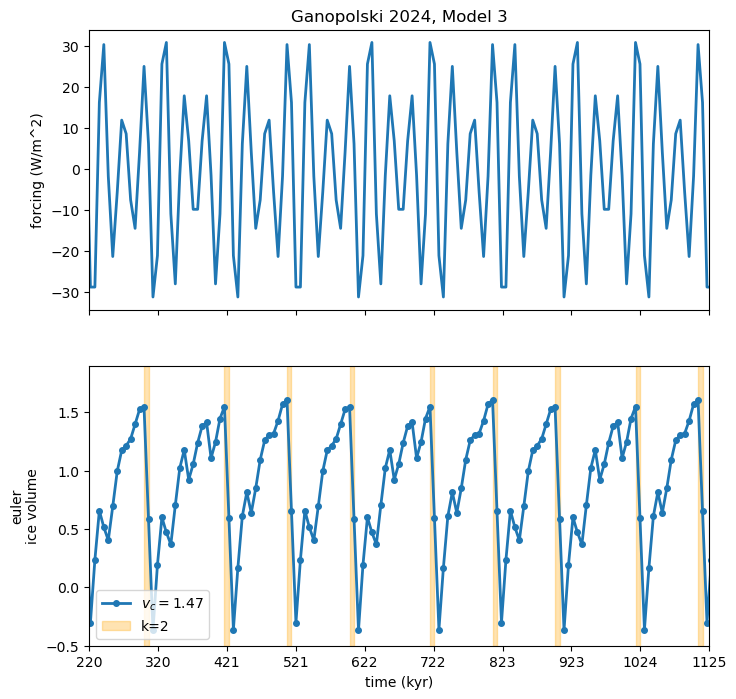

In [408]:
end_kya=75
start_kya=980

model_sols = [model3_euler]
smooth = False
solver_choice = True

t_range = np.arange(max(model_sols[0].solution.t)-start_kya, max(model_sols[0].solution.t)-end_kya, delta_t)
ticks = np.linspace(max(model_sols[0].solution.t)-start_kya, max(model_sols[0].solution.t)-end_kya, 10)  # Generate 6 ticks from 800 to 3000
tick_labels = [str(int(tick)) for tick in ticks]  # Calculate labels 800 to 0

fig, ax = plt.subplots(len(model_sols)+1, 1, sharex=True, figsize=(8, 8))

for ik, model_sol in enumerate(model_sols):
    t_arr = model_sol.diagnostics['t_arr']
    k_arr = model_sol.diagnostics['k_arr']
    
    df = pd.DataFrame({'Time': t_arr, 'k': k_arr})
    df.sort_values('Time', inplace=True)
    df = df[df['Time']>min(t_range)]

    # Identify where 'k' changes
    df['shifted_k'] = df['k'].shift(-1)  # Shift k values down for comparison
    # Start of intervals
    df['start'] = (df['k'] == 2) & (df['k'].shift(1) != 2)
    # End of intervals (note the last interval needs special handling)
    df['end'] = (df['k'] == 2) & (df['shifted_k'] != 2)
    
    # Extract intervals
    intervals = []
    for _, row in df.iterrows():
        if row['start']:
            start_time = row['Time']
        if row['end']:
            end_time = row['Time']
            intervals.append((start_time, end_time))
    
    # Handling case where last interval does not end within the data range
    if df.iloc[-1]['k'] == 2 and not df.iloc[-1]['end']:
        intervals.append((start_time, df.iloc[-1]['Time']))
    
    time = model_sol.solution.t

    model_sol_y = model_sol.solution.y[0]
    model_forcing = model_sol.model.forcing.get_forcing(time)
    label=','.join([r'$v_c=$'+str(model_sol.model.vc)])
    ax[ik+1].plot(time, model_sol_y, linewidth=2, marker='o', markersize=4, label=label)
        
    if len(intervals)>0:
        for ip, interval in enumerate(intervals):
            if ip==0:
                label='k=2'
            else:
                label=None
            ax[ik+1].axvspan(interval[0], interval[1], color='orange', alpha=0.3, label=label)
    ax[ik+1].set_xlim([max(model_sol.solution.t)-start_kya, max(model_sol.solution.t)-end_kya])
    ax[ik+1].legend()
    
    ax[0].plot(time, model_forcing, linewidth=2, label=label)

    ax[0].set_ylabel('forcing (W/m^2)')
    ax[ik+1].set_xticks(ticks)
    ax[ik+1].set_ylim([-.5,1.9])
    ax[ik+1].set_ylabel('\n'.join([model_sol.method,model_sol.model.variable_name]))
    
ax[-1].set_xticklabels(tick_labels)
ax[-1].set_xlabel('time (kyr)')
ax[0].set_title('Ganopolski 2024, Model 3')
plt.savefig('figures/g24_model3_euler_vc1p47.png')